In [5]:
import pymaid
import vispy
import matplotlib.pyplot as plt
import pandas as pd

"""

CATMAID credentials in the form of pymaid.CatmaidInstance(server, authname, authpassword, authtoken)

"""




import datetime
import sys
import csv
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# reload(sys)
# sys.setdefaultencoding("utf-8")
print('Last run:', datetime.date.today())
print('Pymaid version:', pymaid.__version__)

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


Last run: 2019-07-18
Pymaid version: 0.96


# Finding triples

The goal is to use a function to find triples of neurons (source, interneuron, output) provided all three of the following unidirectional exist: source -> inter, source -> output, inter -> motor.


First we need a function to find which connections exist between a single source neuron and a set of output neurons.

The function **direct()** takes a skeleton id of a source neuron, a list of output neurons, and a threshold that represents above how many synapses is a synaptic partner going to be considered- connections with nr. of synapses below or equal will be ignored. This function returns a list of skeleton ids of the filtered targets of the source neuron

In [7]:
target = pymaid.find_neurons(annotations = 'IPCs')
hugin = pymaid.find_neurons(annotations = 'sens2-to-IPCs')

def direct(skid,mot,t):#returns skids of the ou we know are output of the sens
    cons = pymaid.get_partners([skid], directions=['outgoing'], threshold = t)
    mots = mot.skeleton_id.tolist()
    cons_m = [cons.loc[cons['skeleton_id']==n] for n in mots]
    if cons_m:

        direc = pd.concat(cons_m) 
        dirlist = direc['skeleton_id'].tolist()
    else:
        dirlist = []
    return dirlist
 
dir_lista = direct('13744425',target,2)

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


HBox(children=(IntProgress(value=0, description='Make nrn', max=14, style=ProgressStyle(description_width='initial')), HTML(value='')))

INFO  : Found 14 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

INFO  : Found 8 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Done. Found 0 pre-, 50 postsynaptic and 0 gap junction-connected neurons (pymaid)


In [8]:
dir_lista

['3046503',
 '2283495',
 '10459723',
 '4453485',
 '2852273',
 '2357110',
 '10329208',
 '3561724']

The next function **single_triple()** takes a skeleton id of a source neuron, a list of target neurons, a list of interneurons and a synaptic threshold.

A list of all the triples present will be returned, where the neurons are given by their name.

In [4]:
pymaid.get_skids_by_annotation("annotation:sens2-to-IPCs")

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 8 neurons with matching annotation(s) (pymaid)


[9716858, 13744425, 2340336, 15769680, 2284021, 40152, 2456826, 1414206]

In [9]:
def single_triple (skid, mot, hug, t): #skid = skid of a source, mot,hug = already found neurons with an annotation given outside
    triples = []
    allnames = []
    motids = direct(skid,mot,t)
    hugids = direct(skid,hug,t)
    for m in motids:
        h_cons = pymaid.get_partners([m],directions=['incoming'], threshold = t)
        cons_hop = [h_cons.loc[h_cons['skeleton_id']==n] for n in hugids]
        if cons_hop:
            n_hugs = pd.concat(cons_hop)
            hops = n_hugs['skeleton_id'].tolist() #skids of hugins that go to the IPCs we want

            mlist=[([skid,h,m]) for h in hops]
            if len(mlist)!=0:
                triples.append(mlist)
    alist = list(itertools.chain.from_iterable(triples))
    for el in alist:
        if type(el) is list:
            names = [pymaid.get_names(neuron)[neuron] for neuron in el]
            allnames.append(names)
        else:
            allnames.append(pymaid.get_names(el)[el])
    return allnames

s_skid = '40152'
# sin_triples = single_triple(s_skid,target,hugin,2)


In [6]:
sin_triples

[]

Finally, the function **all_triples()** takes as input lists of source neurons, interneurons and target neurons, as well as a synaptic threshold and a csv file name where the output will be saved. This function makes use of the previous function to find all the triples present between the given neuron lists. It returns a list of all the triples and saves it in a csv file, where the neurons are given by names.

In [7]:
p = pymaid.get_neurons('annotation: SE0 LR')
p

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 8 neurons with matching annotation(s) (pymaid)


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

,neuron_name,skeleton_id,n_nodes,n_connectors,n_branch_nodes,n_end_nodes,open_ends,cable_length,review_status,soma
0,SE0 R1,887905,1465,102,49,54,2,162.055439,NA,False
1,SE0 L1,15995012,1698,147,69,72,2,211.953678,NA,True
2,SE0 L3,15769638,1826,123,74,76,5,200.663689,NA,True
3,SE0 L4,15995309,2301,156,76,79,0,314.736108,NA,True
4,SE0 L2,15983118,1956,154,100,107,1,220.225443,NA,True
5,SE0 R2,896562,1818,134,70,76,3,192.510690,NA,True
6,SE0 R4,15573428,2305,153,78,86,0,298.265801,NA,True
7,SE0 R3,15564695,1497,117,52,54,2,186.605950,NA,True


In [8]:
ctable = pymaid.get_partners(p,directions=['incoming'], threshold = 2)
skids = ctable['skeleton_id'].tolist()
type(target)
ctable

INFO  : Fetching connectivity table for 8 neurons (pymaid)
INFO  : Done. Found 127 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


,neuron_name,skeleton_id,num_nodes,relation,887905,15995012,15769638,15995309,15983118,896562,15573428,15564695,total
0,SEZ-IN-A05-right - paired with #6885133,18354200,3581,upstream,0,16,17,1,6,0,0,0,40.0
1,SEZ-IN-08-right,14035921,4314,upstream,7,0,0,0,0,14,7,10,38.0
2,Pre PMN R right,3436420,5682,upstream,0,12,11,0,11,0,0,0,34.0
3,SEZ-X-left,3477008,3568,upstream,0,4,9,1,19,0,0,0,33.0
4,AN-R-Sens-B1-AVa-16,6883831,899,upstream,13,0,0,0,0,11,0,6,30.0
5,SEZ-IN-03-left,18371412,3522,upstream,0,6,16,0,5,0,1,0,28.0
6,AN-R-Sens-B1-AVa-15,15574328,888,upstream,8,0,0,0,0,3,0,16,27.0
7,SEZ-IN-A05-left - paired with #18354200,6885133,3244,upstream,8,0,0,0,0,11,0,7,26.0
8,AN-L-Sens-B1-AVa-17,1375101,746,upstream,0,10,6,0,10,0,0,0,26.0
9,Pre PMN L,6445994,6206,upstream,5,0,0,0,0,12,1,7,25.0


In [9]:
p.skeleton_id.tolist()

['887905',
 '15995012',
 '15769638',
 '15995309',
 '15983118',
 '896562',
 '15573428',
 '15564695']

In [10]:
[n for n in ctable['skeleton_id'].tolist() if n in p]


['15573428']

In [11]:
l = [n for n in ctable if n in p]

In [12]:
pymaid.get_names(l)

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


{'15564695': 'SE0 R3',
 '15573428': 'SE0 R4',
 '15769638': 'SE0 L3',
 '15983118': 'SE0 L2',
 '15995012': 'SE0 L1',
 '15995309': 'SE0 L4',
 '887905': 'SE0 R1',
 '896562': 'SE0 R2'}

In [3]:
def all_triples(sources, targets, interns, t,fname):#returns all triangles (no backward edges)
    sen = pymaid.find_neurons(annotations = sources)
    target = pymaid.find_neurons(annotations = targets)
    inter = pymaid.find_neurons(annotations = interns)
    sens = sen.skeleton_id.tolist()
    all_ = []
    for s in sens:
        st = single_triple(s,target,inter,t)
        if st:
            all_.append(st)
    final = list(itertools.chain.from_iterable(all_)) #list of the triples by skeleton ids
    with open(fname, 'w', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['source','interneuron','target'])
        for triple in final:
            wr.writerow(triple)
    return final

sen1 = 'sens2-to-hugin-ipc'
sen2 = 'sens2-to-hugin-dms'

tar1 = 'IPCs'
tar2 = 'DMS'
intr = 'Hugin PC'
# trips1 = all_triples(sen1,tar1,intr,2)
# trips2 = all_triples(sen2,tar2,intr,2,'triples_0.csv')

The function **all_triples_new()** also returns a list of triples, with the difference that the input is only a list of output neurons and a threshold. This function finds triples by considering all the incoming partners as both interneurons and source neurons.

In [10]:
def all_triples_new(targets,t,fname):#returns all triangles (no backward edges)
    target = pymaid.find_neurons(annotations = targets)
    tarskids = target.skeleton_id.tolist()
    phar = pymaid.get_neurons('annotations:Pharyngeal sensory')
    phids = phar.skeleton_id.tolist()
    ctable = pymaid.get_partners(target,directions=['incoming'], threshold = t)
    skids = ctable['skeleton_id'].tolist()
    sens = skids
    bad_names = [n for n in list(pymaid.get_names(skids).values()) if 'SE0 R4' in n]
    intids = [sk for sk in skids if sk not in phids and sk not in tarskids]
    

    inter = pymaid.get_neuron(intids)
    interskids = [n.skeleton_id for n in inter if n.neuron_name not in bad_names]
    new_inter = pymaid.get_neuron(interskids)
    all_ = [single_triple(s,target,new_inter,t) for s in phids if single_triple(s,target,new_inter,t)]

    final = list(itertools.chain.from_iterable(all_)) #list of the triples by skeleton ids
    with open(fname, 'w', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['source','interneuron','target'])
        for triple in final:
            wr.writerow(triple)
    return final

sen1 = 'sens2-to-hugin-ipc'
sen2 = 'sens2-to-hugin-dms'

tar1 = 'IPCs'
tar2 = 'DMS'
tar3 = 'DH44'
intr = 'Hugin PC'
tar4 = 'Se0ens'

trips1 = all_triples_new(tar4,2,'triples_se0ens_new3.csv')
# trips2 = all_triples(sen2,tar2,intr,2)

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 6 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 349 neurons with matching annotation(s) (pymaid)


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=349, style=ProgressStyle(description_width='initial')), HTML(value='')))

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


HBox(children=(IntProgress(value=0, description='Make nrn', max=349, style=ProgressStyle(description_width='initial')), HTML(value='')))

INFO  : Fetching connectivity table for 6 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 94 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=49, style=ProgressStyle(description_width='initial')), HTML(value='')))

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


HBox(children=(IntProgress(value=0, description='Make nrn', max=49, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Fetch neurons', max=48, style=ProgressStyle(description_width='initial')), HTML(value='')))

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


HBox(children=(IntProgress(value=0, description='Make nrn', max=48, style=ProgressStyle(description_width='initial')), HTML(value='')))

INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 4 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 4 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 19 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 19 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 15 postsynaptic and 0 gap junct

INFO  : Done. Found 0 pre-, 5 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 5 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 8 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 8 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity t

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 24 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 9 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 9 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 12 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_ca

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 10 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 10 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 10 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_c

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 15 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 16 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 19 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymai

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 19 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 15 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 15 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 27 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 9 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 32 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 23 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache(

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 22 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 22 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 16 pre-, 0 postsynaptic and 0 gap junction-conn

INFO  : Done. Found 0 pre-, 6 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 6 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 17 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 17 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 19 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivit

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 7 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 14 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 14 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 31 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `p

INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 6 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 21 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 21 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 4 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to cle

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 10 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 10 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pym

INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 7 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 7 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 7 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 20 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clea

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 6 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 19 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 19 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 17 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_c

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 7 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 9 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 9 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 11 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 11 postsynaptic and

INFO  : Done. Found 0 pre-, 16 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 20 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 20 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 26 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `

INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 20 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 31 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` t

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 32 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 13 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 13 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 24 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 32 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 3 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 3 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()

INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 4 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 4 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 17 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 17 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 33 postsynaptic and 0 gap junct

INFO  : Done. Found 0 pre-, 18 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 18 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 10 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 10 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 8 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivi

INFO  : Done. Found 0 pre-, 4 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 15 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 15 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 31 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `p

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 17 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 3 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 3 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 8 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 8 postsynaptic and 

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 5 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 5 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 32 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 8 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 5 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 5 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 10 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cac

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 6 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 6 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 46 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 46 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neur

INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 7 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 7 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 5 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 5 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 9 postsynaptic and 0 gap junction

INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 4 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 4 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 18 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 18 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 8 postsynaptic and 0 gap juncti

In [11]:
len(trips1)

133

In [8]:
lista = []
for k in range(len(trips1)):
    for trip in trips2:
        if trip[0] in trips1[k] and trip[0] not in lista:
            lista.append(trip[0])
#     lista = [trip[0] for trip in trips2 if trip[0] in trips1[k]]
    
lista

['AN-R-Sens-B1-ACa-01',
 'AN-L-Sens-B1-ACa-01',
 'AN-L-Sens-B1-ACa-10',
 'AN-L-Sens-B1-ACa-02']

# Ranking index



The function **new()** converts to 0 all counts of synapses in the partners table smaller or equal to the given threshold. It will be used in the following functions for filtering connections below a threshold.


In [9]:
def new (df,t):
    nw_df=df.copy(deep=True)
    for n in df.columns[4:]:
        for m in df.index.values:
            v=df.loc[m].at[n]
            if int(v)<t:
                nw_df.at[m,n]=0
    return nw_df


First, a function is needed to find the ranking index of the unidirectional connection between two single neurons, source -> target, defined as the *number of synapses between neuron s and a target neuron m, divided by the highest number of synapses among all incoming synaptic connections to m*

**rank_idx()** takes as input two neuron names, (s- source and m- target), the min. nr. of incoming synapses to the target (tr-threshold) and minimum node count for partner (mins)

The returned value is the ranking index of the incoming edge to the target neuron from the source (range:0-1, two decimal places)

In [10]:
def rank_idx (s,m,tr,mins): 
    sen = pymaid.find_neurons(s)
    mot = pymaid.find_neurons(m)
    mcons=pymaid.get_partners(mot,directions=['incoming'], min_size = mins)
    n_cons=new(mcons,tr)
    sens=sen.skeleton_id.tolist()

    cons = [n_cons.loc[n_cons['skeleton_id']==n] for n in sens]
    result = pd.concat(cons)
    r = sum(result.total)
    t = mcons.total[0]
    return round(r/t,2)

pymaid.clear_cache()
test1 = rank_idx('AN-L-Sens-B1-ACa-01', 'hugin-PC left 4',2,1)


INFO  : Cached cleared. (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Done. Found 48 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


In [11]:
test1

0.78

The function **ranks_all ()** takes as input two lists of neuron names, (inputs and targets), the min. nr. of incoming synapses to the target (tr-threshold) and minimum node count for partner (mins), and uses rank_idx() to find the ranking indexes of all connections between the neurons in the given input and target lists.

The output is a dataframe with the ranking indexes between the inputs (rows) and the targets (columns)

In [12]:
def ranks_all (inputs,targets,tr,mins):
    df = pd.DataFrame([[rank_idx(sen,tar,tr,mins) for tar in targets] for sen in inputs], index = inputs, columns = targets)
    return df

pymaid.clear_cache()
sensories = pymaid.get_names('annotation:sens2-to-hugin-dms').values()
inters = pymaid.get_names('annotation:DMS').values()
test2 = ranks_all(sensories,inters,2,1)

INFO  : Cached cleared. (pymaid)
INFO  : Found 7 neurons with matching annotation(s) (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 4 neurons with matching annotation(s) (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Done. Found 35 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Done. Found 27 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 35 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 27 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 35 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 27 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 35 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 27 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 35 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 27 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 35 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 27 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 35 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 30 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 27 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


In [13]:
test2

,DMS 1 right,DMS 1 left,DMS 2 left,DMS 2 right
AN-L-Sens-B1-ACa-10,0.0,0.57,0.33,0.00
AN-L-Sens-B1-ACa-11,0.0,0.43,0.00,0.00
AN-L-Sens-B1-ACa-01,0.0,0.71,0.78,0.00
AN-R-Sens-B1-ACa-01,0.0,1.00,0.44,0.00
AN-L-Sens-B1-ACa-02,1.0,0.29,0.67,0.29
AN-R-Sens-B1-ACa-09,0.0,0.00,0.00,0.57
AN-R-Sens-B1-ACa-08,0.0,0.00,0.00,0.43


# Plotting triples in a graph

First, a function that plots a single triple is defined: **single_network()**. It takes as input a skeleton id of a source neuron, a list of targets, a list of interneurons, and a synaptic threshold (the same input as in single_triple). The output is a network graph showing the neurons that are part of triples accordingly connected by edges. The edge labels are the ranking indexes for the connections.

In [14]:
pymaid.get_skids_by_name('AN-L-Sens-B1-ACa-02')

,name,skeleton_id
0,AN-L-Sens-B1-ACa-02,13744425


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Found 14 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Found 8 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Done. Found 0 pre-, 50 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 50 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 23 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 25 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 22 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 19 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching conn

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Done. Found 52 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 33 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 33 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Done. Found 40 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 33 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 33 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 52 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 38 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 38 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 52 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 31 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 31 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 40 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 31 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 31 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 52 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 43 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 43 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 40 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 43 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 43 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
/srv/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



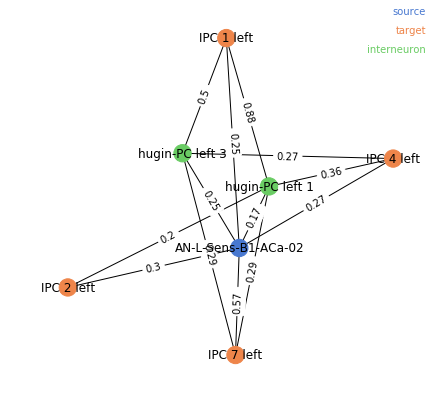

In [15]:
def single_network(sen, tars, hugs,tr):

    trips = single_triple(sen,tars,hugs,tr)
    tarrs = tars.skeleton_id.tolist()
    s_names = [triple[0] for triple in trips]
    t_names = [pymaid.get_names(neuron)[neuron] for neuron in tarrs]
    
    G = nx.Graph()
    colours = sns.color_palette('muted', 3)
    source = pymaid.get_names(sen)[sen]
    G.add_node(source)
    for el in trips:
        r1 = rank_idx(el[0],el[1],2,1)
        r2 = rank_idx(el[0],el[2],2,1)
        r3 = rank_idx(el[1],el[2],2,1)

        G.add_node(el[1])
        G.add_node(el[2])

        G.add_edge(source,el[1],r = r1)
        G.add_edge(source,el[2],r = r2)
        G.add_edge(el[1],el[2], r = r3)
        edge_labels = nx.get_edge_attributes(G,'r')

    cmap = { n : colours[0] for n in s_names }
    cmap.update( { n : colours[1] for n in t_names} )
    cmap.update( { n : colours[2] for n in G.nodes if n not in s_names and n not in t_names })
    pos = nx.layout.spring_layout(G,scale = 50)

    fig, ax = plt.subplots(figsize=(7,7))
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
    nx.draw(G, pos, node_color=[cmap[n] for n in G.nodes], ax = ax, with_labels = True)

    ax.text(x=1,y=1,
            s='source',
            color=colours[0],
            fontsize=10, ha='right', va='top',
            transform=ax.transAxes)
    ax.text(x=1,y=0.95,
            s='target',
            color=colours[1],
            fontsize=10, ha='right', va='top',
            transform=ax.transAxes)
    ax.text(x=1,y=0.90,
            s='interneuron',
            color=colours[2],
            fontsize=10, ha='right', va='top',
            transform=ax.transAxes)
    
    ax.margins(0.1)
    plt.show()
    return G

target = pymaid.find_neurons(annotations = 'IPCs')
hugin = pymaid.find_neurons(annotations = 'Hugin PC')
#s_skid = '13744425'
single_graph = single_network('13744425',target,hugin,2)

In [16]:
single_graph

Building upon the previous function, the function **all_networks()** plots a network of triples for multiple source neurons. As arguments it takes annotations of input, output and interneurons, and a synaptic threshold (the same arguments as all_triples()). 

It returns a graph with all the triples connected by appropriate edges, where the edge label is again the ranking index.

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Found 6 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 14 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 8 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Done. Found 0 pre-, 13 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 0 pre-, 13 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 22 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 32 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Done. Found 48 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 38 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 38 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Done. Found 45 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 44 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 44 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 48 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 40 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 40 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 48 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 38 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 38 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 48 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 40 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 40 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 48 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 28 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 28 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 52 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 35 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 35 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 52 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 33 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 33 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 40 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 33 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 33 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 52 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 38 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 38 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 52 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 31 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 31 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 40 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 31 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 31 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 52 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 43 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 43 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 40 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 43 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 43 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)


INFO  : Done. Found 45 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 34 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 34 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Done. Found 45 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 36 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 1 neurons matching the search parameters (pymaid)
INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Done. Found 36 pre-, 0 postsynaptic and 0 gap junction-connected neurons (pymaid)


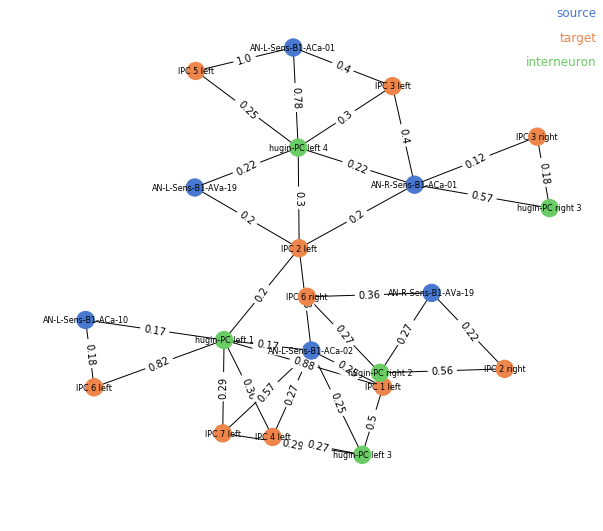

In [18]:
def all_networks(sens,tars,hugs,tr):
    trips = all_triples(sens,tars,hugs,tr)
    s_names = [triple[0] for triple in trips]
    h_names = [triple[1] for triple in trips]
    t_names = [triple[2] for triple in trips]
    G = nx.Graph()
    colours = sns.color_palette('muted', 3)
    flat = list(itertools.chain.from_iterable(trips))
    for el in flat:
        G.add_node(el)

    for group in trips:
        G.add_edge(group[0],group[1], r = rank_idx(group[0],group[1],2,1))
        G.add_edge(group[1],group[2], r = rank_idx(group[1],group[2],2,1))
        G.add_edge(group[0],group[2], r = rank_idx(group[0],group[2],2,1))


    pos = nx.layout.kamada_kawai_layout(G,scale=10)
    cmap = { n : colours[0] for n in s_names }
    cmap.update( { n : colours[1] for n in t_names} )
    cmap.update( { n : colours[2] for n in G.nodes if n not in s_names and n not in t_names })

    fig, ax = plt.subplots(figsize=(10,10))

    edge_labels = nx.get_edge_attributes(G,'r')

    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 10)

    nx.draw(G, pos, 
            node_color=[cmap[n] for n in G.nodes], ax = ax, with_labels = True, font_size = 8)

    # Add legend
    ax.text(x=1,y=1,
            s='source',
            color=colours[0],
            fontsize=12, ha='right', va='top',
            transform=ax.transAxes)
    ax.text(x=1,y=0.95,
            s='target',
            color=colours[1],
            fontsize=12, ha='right', va='top',
            transform=ax.transAxes)
    ax.text(x=1,y=0.90,
            s='interneuron',
            color=colours[2],
            fontsize=12, ha='right', va='top',
            transform=ax.transAxes)
    fig.autofmt_xdate()

    ax.margins(0.1)
    plt.show()
    return G

sen = 'sens2-to-hugin-ipc'
tar = 'IPCs'
intr = 'Hugin PC'

all_graph = all_networks(sen,tar,intr,2)


In [ ]:
all_graph